In [1]:
# https://github.com/marshackVB/ml-recipes/blob/master/PandasUDF_Hyperopt_Spark.ipynb
# https://www.phdata.io/blog/bayesian-hyperparameter-optimization-with-mlflow/

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from datetime import date,datetime,timedelta

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import StringType, DoubleType, StructType, StructField, DateType, FloatType
from pyspark.sql.functions import *

# initialise sparkContext
spark = SparkSession.builder \
    .master('local') \
    .appName('myAppName') \
    .config('spark.executor.memory', '10gb') \
    .config("spark.cores.max", "6") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
sqlContext = SQLContext(sc)

import os
from functions.func import *

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# 1. Paramaters

In [2]:
experiment_name = "forecast_pyspark"
days_to_forecast = 14
last_train_date = date(2021, 12, 31)
use_sample_data = True

# 2. Data Input

In [3]:
df_input = sqlContext.read.parquet("sample_data/sample_data.parquet")

In [4]:
if not use_sample_data:
    # to read parquet file
    df_input = sqlContext.read.parquet('data/forecast_encoded_data.parquet')
    df_input = df_input.filter( ( col('Key1') == 'N01') & (col('Key2').isin(['76', '62']) ) )

    unique_ts = df_input_train.select(['Key1', 'Key2']).drop_duplicates().toPandas()
    
label_col = 'y'
feature_cols = [column for column in df_input.columns if column not in [label_col, 'ds', 'Forecast', 'Key1','Key2']]

df_input_train = df_input.filter(col('ds') <= last_train_date )
df_input_test = df_input.filter(col('ds') > last_train_date )

In [5]:
check_key1 = 'N01'
check_key2 = '76'
df_input_train.filter( (col('Key1') == check_key1) &  (col('Key2') == check_key2) & (col('ds') > '2021-11-01')  ).sort(col('ds')).show()

+----+----+-------------------+----+-----+---------+---+
|Key1|Key2|                 ds|year|month|dayofweek|  y|
+----+----+-------------------+----+-----+---------+---+
| N01|  76|2021-11-02 00:00:00|2021|   11|        3|100|
| N01|  76|2021-11-03 00:00:00|2021|   11|        4|189|
| N01|  76|2021-11-04 00:00:00|2021|   11|        5|313|
| N01|  76|2021-11-05 00:00:00|2021|   11|        6|311|
| N01|  76|2021-11-06 00:00:00|2021|   11|        7| 59|
| N01|  76|2021-11-07 00:00:00|2021|   11|        1|  0|
| N01|  76|2021-11-08 00:00:00|2021|   11|        2|221|
| N01|  76|2021-11-09 00:00:00|2021|   11|        3|228|
| N01|  76|2021-11-10 00:00:00|2021|   11|        4| 72|
| N01|  76|2021-11-11 00:00:00|2021|   11|        5|335|
| N01|  76|2021-11-12 00:00:00|2021|   11|        6|302|
| N01|  76|2021-11-13 00:00:00|2021|   11|        7| 70|
| N01|  76|2021-11-14 00:00:00|2021|   11|        1|  0|
| N01|  76|2021-11-15 00:00:00|2021|   11|        2|166|
| N01|  76|2021-11-16 00:00:00|

# 3. Model Training

In [15]:
# Hyperopt search space
search_space = {
  'n_estimators':scope.int(hp.uniform('n_estimators',150,500)),
  #'max_depth':scope.int(hp.uniform('max_depth',5,15)),
  #'min_samples_leaf':scope.int(hp.uniform('min_samples_leaf',1,5)),
  #'min_samples_split':scope.int(hp.uniform('min_samples_split',2,6)), #num_features_for_split = sqrt(total_input_features)
  #'max_samples': hp.uniform("max_samples",0.5, 1)
}


# Pandas_UDF requires a Spark Schema that matches the output of the UDF
fit_schema = StructType([StructField('node', StringType(), True),
                         StructField('best_model_score', DoubleType(), True)])


fit_models = fit_models_config(feature_cols = feature_cols, 
                               label_col = label_col,
                               model = RandomForestRegressor,
                               search_space = search_space,
                               days_to_forecast = days_to_forecast,
                               experiment_name = experiment_name,
                               scoring = 'smape', # or sklearn scores, e.g. 'neg_mean_squared_error',
                               cv=3
                                )

In [16]:
best_model_stats = df_input_train.groupBy('Key1','Key2').applyInPandas(fit_models,schema=fit_schema)

In [17]:
%%time
best_model_stats.show()

+------+----------------+
|  node|best_model_score|
+------+----------------+
|N01_62|          0.4494|
|N01_76|          0.6141|
+------+----------------+

CPU times: user 31.7 ms, sys: 6.7 ms, total: 38.4 ms
Wall time: 4min 55s


## 3. Model Evaluation

In [18]:
# Define the schema for the UDF's output DataFrame
forecast_schema =StructType([
  StructField('ds',DateType()),
  StructField('Key1',StringType()),
  StructField('Key2',StringType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_lower',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('run_id',StringType())
  ])

experiment_id = '1'
apply_models = apply_models_config(features_cols = feature_cols,  experiment_id=experiment_id)

# 4. Plot

In [19]:
check_key1 = 'N01' # N01_62
check_key2 = '76'
group_name = '{}_{}'.format(check_key1, check_key2)
experiment_id = '1'

# extract the forecast for a specific ts_key as example
forecast = (df_input.filter((col("Key1") == check_key1) 
                             & (col("Key2") == check_key2))
                            .groupBy('Key1', 'Key2')
                            .applyInPandas(apply_models, schema = forecast_schema ))

forecast_pd = (
    forecast
    .select(['ds','y','yhat','yhat_lower','yhat_upper'])
    .filter((col('Key1')==check_key1) & (col('Key2')==check_key2))
    ).toPandas()


In [20]:
model, best_run_df, model_cv_smape = load_model(check_key1, check_key2, experiment_id, group_name)

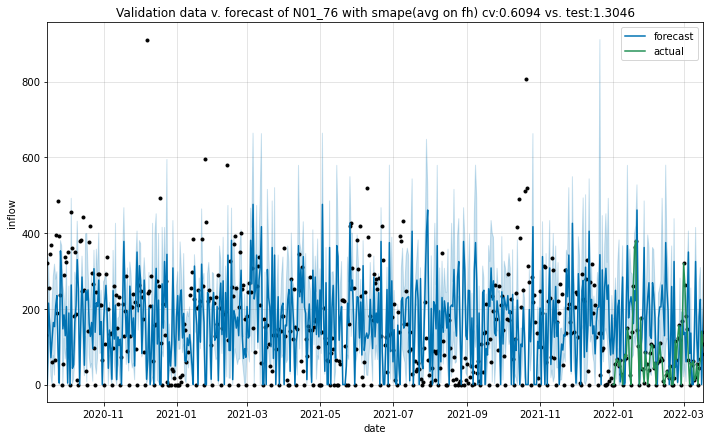

In [21]:
plot_forecast(forecast_pd, model_cv_smape, last_train_date, model, group_name )

In [22]:
check_key1 = 'N01' # N01_62
check_key2 = '62'
group_name = '{}_{}'.format(check_key1, check_key2)
experiment_id = '1'

# extract the forecast for a specific ts_key as example
forecast = (df_input.filter((col("Key1") == check_key1) 
                             & (col("Key2") == check_key2))
                            .groupBy('Key1', 'Key2')
                            .applyInPandas(apply_models, schema = forecast_schema ))

# extract the forecast for a specific ts_key as example
forecast_pd = (
    forecast
    .select(['ds','y','yhat','yhat_lower','yhat_upper'])
    .filter((col('Key1')==check_key1) & (col('Key2')==check_key2))
    ).toPandas()

model, best_run_df, model_cv_smape = load_model(check_key1, check_key2, experiment_id, group_name)

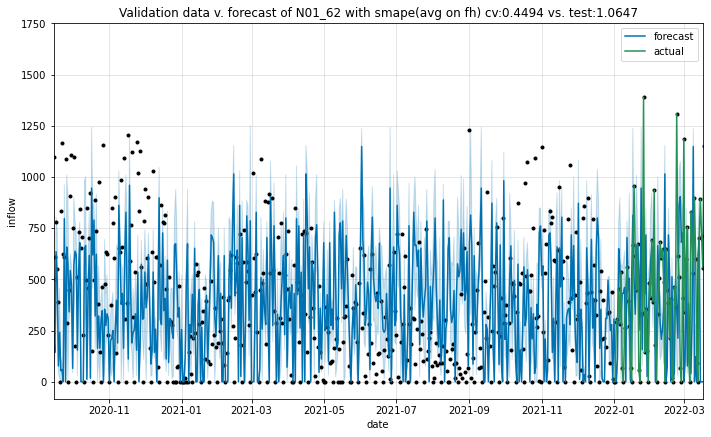

In [23]:
plot_forecast(forecast_pd, model_cv_smape, last_train_date, model, group_name )